> 现在的ODE结果存在错误，可能Richards方程写的不对

In [55]:
include("main_ode.jl")
using JLD2

u0 = fill(0.1, n) |> collect # Example initial soil moisture profile
tspan = (0.0, 0.8*3600)  # Time span for the simulation
# p = (; dz, dt, θ0, ψ0, z, z₊ₕ, K=zeros(n), ψ=zeros(n), param=param)

bonan = load("data/output_bonan.jld2")

Dict{String, Any} with 2 entries:
  "ψ" => [-20.9214, -20.9215, -20.9218, -20.922, -20.9223, -20.9226, -20.923, -…
  "θ" => [0.267, 0.266999, 0.266998, 0.266997, 0.266996, 0.266995, 0.266994, 0.…

In [60]:
prob = ODEProblem(soil_moisture_transport, u0, tspan, p);
@time sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6, saveat=200);
# nothing

  0.490182 seconds (40.68 k allocations: 2.835 MiB)


retcode: Success
Interpolation: 1st order linear
t: 16-element Vector{Float64}:
    0.0
  200.0
  400.0
  600.0
  800.0
 1000.0
 1200.0
 1400.0
 1600.0
 1800.0
 2000.0
 2200.0
 2400.0
 2600.0
 2800.0
 2880.0
u: 16-element Vector{Vector{Float64}}:
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
 [0.2662876482750894, 0.2646685736734966, 0.26257345985987396, 0.2598223526445092, 0.2561001987860909, 0.25089973845363767, 0.24333724061784862, 0.23185227076212273, 0.2138291002334901, 0.18627726084356322  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
 [0.2667179396515069, 0.26609725990422156, 0.26535334464080956, 0.26445687266275875, 0.26336846189701735, 0.2620351755474911, 0.26038374596013536, 0.25831076048278195, 0.2556663726742401, 0.2522276152495444  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
 [0.26685953126269973, 0.26655505064196183, 0.2661979374307763, 0.2657798443617551, 0.26528800427573973, 0.26470838178535155, 0

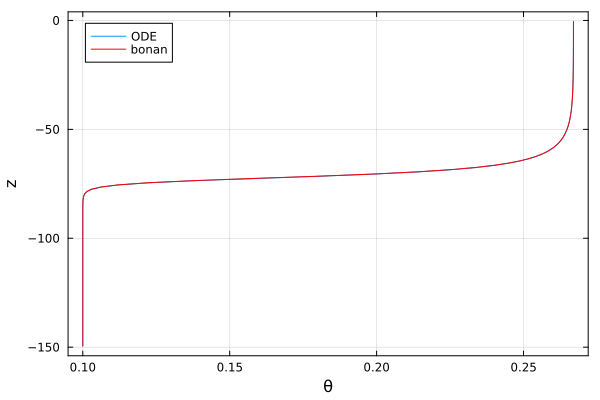

In [61]:
gr(; framestyle=:box)
_u = sol.u[end]
ψ = van_genuchten_ψ.(_u; param)
p1 = plot(sol.u[end], z; xlabel="θ", ylabel="z", label="ODE")

plot!(p1, bonan["θ"], z; label="bonan", color=:red)
# p2 = plot(ψ, z; xlabel="ψ", ylabel="z", label="ψ")
# plot(p1, p2)

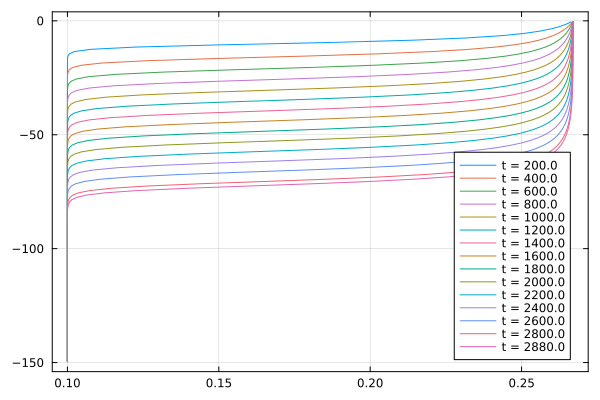

In [62]:
fig = plot()
for i in 1:length(sol.u)-1
  _u = sol.u[i+1]
  _t = sol.t[i+1]
  plot!(fig, _u, z; label="t = $_t")
end
# _u = cat(sol.u..., dims=2)
fig